Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch: 2.8.0+cu126
GPU: Tesla T4
DEPRECATION: Loading egg at /root/.local/lib/python3.12/site-packages/MultiScaleDeformableAttention-1.0-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/MultiScaleDeformableAttention-1.0-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Preparing metadata (setup.py) ... done
DEPRECATION: Loading egg at /root/.local/lib/python3.12/site-packages/MultiScaleDeformableAttention-1.0-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will en

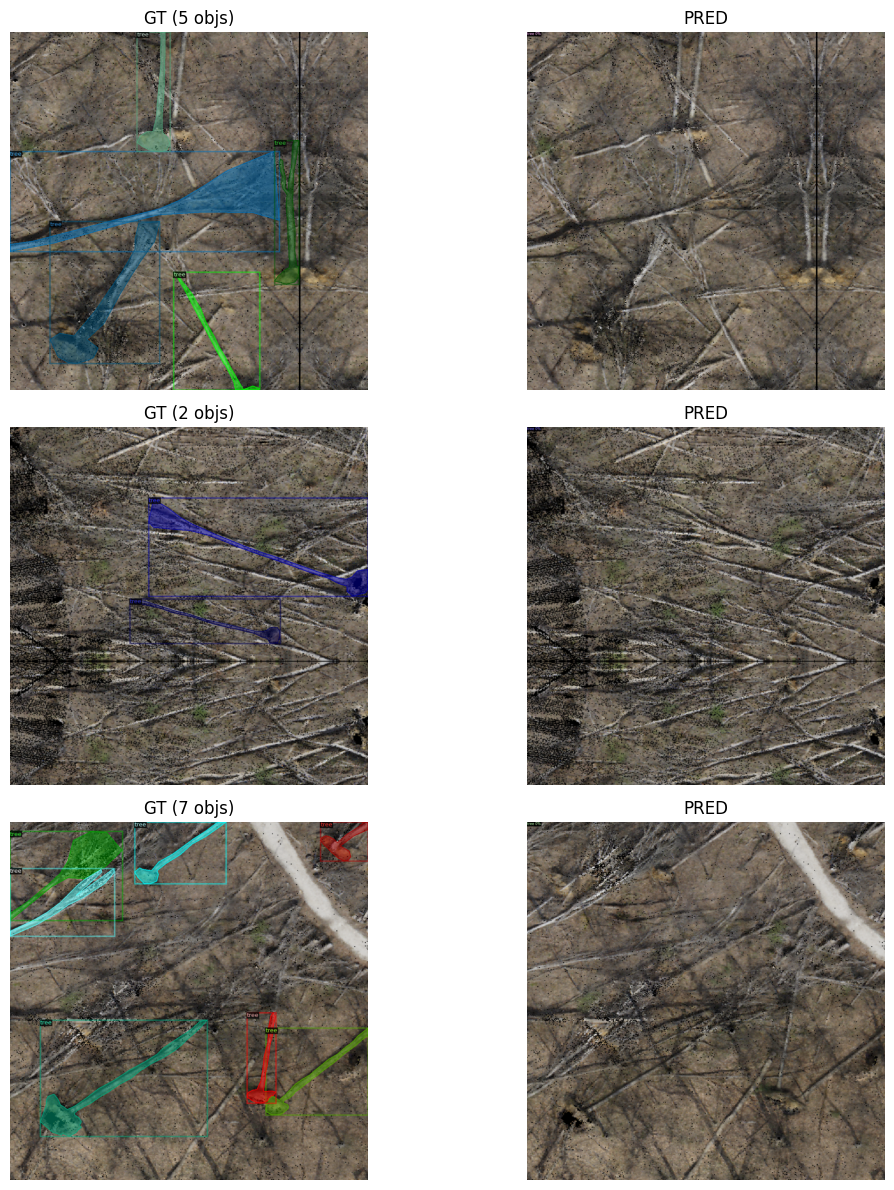

In [ ]:

import os, sys, glob, json, time, subprocess, shutil, textwrap, random, warnings
import torch
warnings.filterwarnings("ignore", message="torch.meshgrid:*")  # cosmetic

from google.colab import drive
drive.mount('/content/drive')

print("PyTorch:", torch.__version__)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU detected. (Runtime > Change runtime type > GPU)")

!pip -q install "git+https://github.com/facebookresearch/detectron2.git"
!pip -q install opencv-python-headless matplotlib tqdm termcolor

M2F_DIR = "/content/Mask2Former"
if not os.path.exists(M2F_DIR):
    !git clone -q https://github.com/facebookresearch/Mask2Former.git /content/Mask2Former

!pip -q install -r /content/Mask2Former/requirements.txt

cu_path = "/content/Mask2Former/mask2former/modeling/pixel_decoder/ops/src/cuda/ms_deform_attn_cuda.cu"
if os.path.exists(cu_path):
    with open(cu_path, "r", encoding="utf-8") as f:
        cu_src = f.read()
    patched = (cu_src
        .replace("value.type()", "value.scalar_type()")
        .replace("value.scalar_type().is_cuda()", "value.is_cuda()")
        .replace("grad_output_g.type()", "grad_output_g.scalar_type()")
        .replace("grad_output_g.scalar_type().is_cuda()", "grad_output_g.is_cuda()")
    )
    if patched != cu_src:
        with open(cu_path, "w", encoding="utf-8") as f:
            f.write(patched)
        print("✅ Patched ms_deform_attn_cuda.cu for PyTorch 2.x")


OPS_DIR = "/content/Mask2Former/mask2former/modeling/pixel_decoder/ops"
os.chdir(OPS_DIR)

if os.path.exists("build"):
    shutil.rmtree("build")

built_ok = False
try:
    print("🛠️  Building CUDA op via setup.py ...")
    subprocess.run([sys.executable, "setup.py", "build", "install", "--user"], check=True)
    built_ok = True
except Exception as e:
    print("⚠️ setup.py build failed:", e)

# Fallback to make.sh if available
if not built_ok and os.path.exists(os.path.join(OPS_DIR, "make.sh")):
    try:
        print("🛠️  Building CUDA op via make.sh ...")
        subprocess.run(["bash", "make.sh"], check=True)
        built_ok = True
    except Exception as e:
        print("⚠️ make.sh build failed:", e)

# Final import check
try:
    import MultiScaleDeformableAttention as MSDA  # must succeed
    print("✅ MultiScaleDeformableAttention op available.")
except ModuleNotFoundError:
    raise ModuleNotFoundError(textwrap.dedent("""
        ❌ Could not import MultiScaleDeformableAttention.
        Tried building with setup.py and make.sh.
        Ensure GPU runtime is enabled and rerun the cell top-to-bottom.
    """))

WORK_DIR   = "/content/drive/MyDrive/mask2former_task"
OUTPUT_DIR = f"{WORK_DIR}/output_full_training_v2"
VAL_JSON   = f"{WORK_DIR}/coco_format/instances_val.json
VAL_IMGDIR = f"{WORK_DIR}/preprocessed_data/val_PNG"

assert os.path.exists(OUTPUT_DIR), f"Missing: {OUTPUT_DIR}"
assert os.path.exists(VAL_JSON),   f"Missing: {VAL_JSON}"
assert os.path.exists(VAL_IMGDIR), f"Missing: {VAL_IMGDIR}"

# Detect latest checkpoint & config
ckpts = sorted(glob.glob(os.path.join(OUTPUT_DIR, "model_*.pth")))
if not ckpts:
    mf = os.path.join(OUTPUT_DIR, "model_final.pth")
    if os.path.exists(mf):
        ckpts = [mf]
    else:
        raise FileNotFoundError("No checkpoints found in OUTPUT_DIR.")
latest_ckpt = ckpts[-1]

cfg_path = os.path.join(OUTPUT_DIR, "config.yaml")
assert os.path.exists(cfg_path), f"Missing config.yaml at {cfg_path}"

print("📦 Using checkpoint:", os.path.basename(latest_ckpt))
print("⚙️  Using config:", os.path.basename(cfg_path))

# Build config & dataset
sys.path.insert(0, "/content/Mask2Former")

from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from mask2former import add_maskformer2_config
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model

VAL_NAME = "tree_val_full"
if VAL_NAME not in DatasetCatalog.list():
    register_coco_instances(VAL_NAME, {}, VAL_JSON, VAL_IMGDIR)
    MetadataCatalog.get(VAL_NAME).set(thing_classes=["tree"])

cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file(cfg_path)

# --- ensure #classes and compute safe topk
num_classes = len(MetadataCatalog.get(VAL_NAME).thing_classes) or 1
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = num_classes

num_queries = int(getattr(cfg.MODEL.MASK_FORMER, "NUM_OBJECT_QUERIES", 100))
cfg_topk = int(getattr(cfg.MODEL.MASK_FORMER.TEST, "TOPK_PER_IMAGE", 100))
safe_topk = max(1, min(cfg_topk, num_queries * num_classes))
cfg.MODEL.MASK_FORMER.TEST.TOPK_PER_IMAGE = safe_topk

print(f"[Eval config] classes={num_classes}, queries={num_queries}, TOPK_PER_IMAGE={safe_topk}")

cfg.MODEL.WEIGHTS = ""  # we’ll load state dict manually

# Load model weights and override runtime attributes
model = build_model(cfg)
model.eval()

state = torch.load(latest_ckpt, map_location="cpu")
if isinstance(state, dict) and "model" in state:
    weights = state["model"]
elif isinstance(state, dict) and "state_dict" in state:
    raw = state["state_dict"]
    weights = { (k[6:] if k.startswith("model.") else k): v for k, v in raw.items() }
else:
    weights = state

missing, unexpected = model.load_state_dict(weights, strict=False)
print("🔧 load_state_dict -> missing:", len(missing), "unexpected:", len(unexpected))

# Make sure head & test k match exactly on the instantiated module
if hasattr(model, "sem_seg_head") and hasattr(model.sem_seg_head, "num_classes"):
    model.sem_seg_head.num_classes = num_classes
if hasattr(model, "test_topk_per_image"):
    model.test_topk_per_image = int(safe_topk)  # <-- CRITICAL: override live attribute

# Evaluate (COCO segm)
eval_dir = os.path.join(OUTPUT_DIR, "eval_results_clean")
os.makedirs(eval_dir, exist_ok=True)

evaluator = COCOEvaluator(VAL_NAME, output_dir=eval_dir, tasks=("segm",))
val_loader = build_detection_test_loader(cfg, VAL_NAME)

print("\n📊 Running evaluation ...")
results = inference_on_dataset(model, val_loader, evaluator)

def getv(d, *keys, default="N/A"):
    cur = d
    try:
        for k in keys:
            cur = cur[k]
        return cur
    except Exception:
        return default

print("\n" + "="*70)
print("RESULTS (segm)")
print("="*70)
for k in ["AP","AP50","AP75","APs","APm","APl"]:
    v = getv(results, "segm", k, default=float("nan"))
    try: print(f"{k}: {v:.2f}%")
    except: print(k, v)
print("="*70)

with open(os.path.join(eval_dir, "results.json"), "w") as f:
    json.dump(results, f, indent=2)
print(f"\n✅ Results saved to: {eval_dir}/results.json")

# visualization
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode

predictor = DefaultPredictor(cfg)
predictor.model.load_state_dict(weights, strict=False)
predictor.model.eval()
if hasattr(predictor.model, "test_topk_per_image"):
    predictor.model.test_topk_per_image = int(safe_topk)  # <-- CRITICAL for predictor too

dataset_dicts = DatasetCatalog.get(VAL_NAME)
if len(dataset_dicts) > 0:
    samples = random.sample(dataset_dicts, min(3, len(dataset_dicts)))

    fig, axes = plt.subplots(len(samples), 2, figsize=(12, 4*len(samples)))
    if len(samples) == 1:
        axes = [axes]  # unify indexing

    meta = MetadataCatalog.get(VAL_NAME)

    for i, d in enumerate(samples):
        img = cv2.cvtColor(cv2.imread(d["file_name"]), cv2.COLOR_BGR2RGB)

        # GT
        v_gt = Visualizer(img, metadata=meta, scale=0.8)
        vis_gt = v_gt.draw_dataset_dict(d)

        # Pred
        outputs = predictor(img)
        v_pr = Visualizer(img, metadata=meta, scale=0.8, instance_mode=ColorMode.IMAGE)
        vis_pr = v_pr.draw_instance_predictions(outputs["instances"].to("cpu"))

        axes[i][0].imshow(vis_gt.get_image());  axes[i][0].set_title(f"GT ({len(d.get('annotations', []))} objs)"); axes[i][0].axis('off')
        axes[i][1].imshow(vis_pr.get_image());  axes[i][1].set_title("PRED");                                       axes[i][1].axis('off')

    plt.tight_layout()
    out_png = os.path.join(eval_dir, "predictions.png")
    plt.savefig(out_png, dpi=150, bbox_inches="tight")
    print(f"✅ Saved sample viz to: {out_png}")
else:
    print("ℹ️ No images found in the validation set for visualization.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch: 2.8.0+cu126
GPU: Tesla T4
DEPRECATION: Loading egg at /root/.local/lib/python3.12/site-packages/MultiScaleDeformableAttention-1.0-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/MultiScaleDeformableAttention-1.0-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Preparing metadata (setup.py) ... done
DEPRECATION: Loading egg at /root/.local/lib/python3.12/site-packages/MultiScaleDeformableAttention-1.0-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will en

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/content/Mask2Former/mask2former/modeling/pixel_decoder/ops/modules/ms_deform_attn.py:87: SyntaxWarning: invalid escape sequence '\s'
  :param input_flatten               (N, \sum_{l=0}^{L-1} H_l \cdot W_l, C)
/content/Mask2Former/mask2former/modeling/pixel_decoder/msdeformattn.py:314: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


[Eval config] classes=1, queries=50, TOPK_PER_IMAGE=50
🔧 load_state_dict -> missing: 0 unexpected: 0

📊 Running evaluation ...
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] 

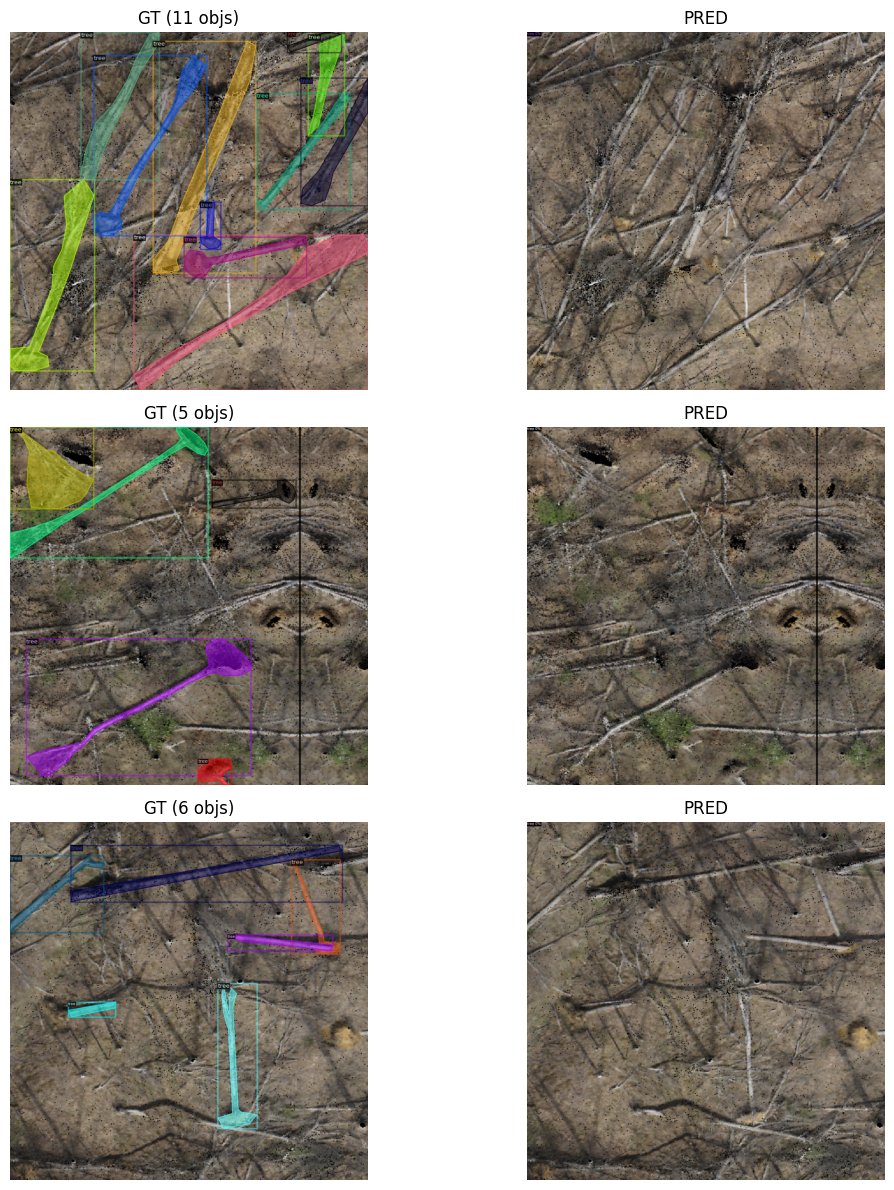

In [ ]:

import os, sys, glob, json, time, subprocess, shutil, textwrap, random, warnings
import torch
warnings.filterwarnings("ignore", message="torch.meshgrid:*")  # cosmetic

from google.colab import drive
drive.mount('/content/drive')

print("PyTorch:", torch.__version__)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU detected. (Runtime > Change runtime type > GPU)")

!pip -q install "git+https://github.com/facebookresearch/detectron2.git"
!pip -q install opencv-python-headless matplotlib tqdm termcolor

M2F_DIR = "/content/Mask2Former"
if not os.path.exists(M2F_DIR):
    !git clone -q https://github.com/facebookresearch/Mask2Former.git /content/Mask2Former

!pip -q install -r /content/Mask2Former/requirements.txt

# PyTorch 2.x compatibility patch for ms_deform_attn CUDA (idempotent)
cu_path = "/content/Mask2Former/mask2former/modeling/pixel_decoder/ops/src/cuda/ms_deform_attn_cuda.cu"
if os.path.exists(cu_path):
    with open(cu_path, "r", encoding="utf-8") as f:
        cu_src = f.read()
    patched = (cu_src
        .replace("value.type()", "value.scalar_type()")
        .replace("value.scalar_type().is_cuda()", "value.is_cuda()")
        .replace("grad_output_g.type()", "grad_output_g.scalar_type()")
        .replace("grad_output_g.scalar_type().is_cuda()", "grad_output_g.is_cuda()")
    )
    if patched != cu_src:
        with open(cu_path, "w", encoding="utf-8") as f:
            f.write(patched)
        print("✅ Patched ms_deform_attn_cuda.cu for PyTorch 2.x")

OPS_DIR = "/content/Mask2Former/mask2former/modeling/pixel_decoder/ops"
os.chdir(OPS_DIR)

# Clean any previous builds
if os.path.exists("build"):
    shutil.rmtree("build")

built_ok = False
try:
    print("🛠️  Building CUDA op via setup.py ...")
    subprocess.run([sys.executable, "setup.py", "build", "install", "--user"], check=True)
    built_ok = True
except Exception as e:
    print("⚠️ setup.py build failed:", e)

# Fallback to make.sh if available
if not built_ok and os.path.exists(os.path.join(OPS_DIR, "make.sh")):
    try:
        print("🛠️  Building CUDA op via make.sh ...")
        subprocess.run(["bash", "make.sh"], check=True)
        built_ok = True
    except Exception as e:
        print("⚠️ make.sh build failed:", e)

# Final import check
try:
    import MultiScaleDeformableAttention as MSDA  # must succeed
    print("✅ MultiScaleDeformableAttention op available.")
except ModuleNotFoundError:
    raise ModuleNotFoundError(textwrap.dedent("""
        ❌ Could not import MultiScaleDeformableAttention.
        Tried building with setup.py and make.sh.
        Ensure GPU runtime is enabled and rerun the cell top-to-bottom.
    """))

WORK_DIR   = "/content/drive/MyDrive/mask2former_task"      # project root
OUTPUT_DIR = f"{WORK_DIR}/output_full_training_v2"          # where model_*.pth + config.yaml are saved
VAL_JSON   = f"{WORK_DIR}/coco_format/instances_val.json"   # COCO val annotations
VAL_IMGDIR = f"{WORK_DIR}/preprocessed_data/val_PNG"        # COCO val images dir

assert os.path.exists(OUTPUT_DIR), f"Missing: {OUTPUT_DIR}"
assert os.path.exists(VAL_JSON),   f"Missing: {VAL_JSON}"
assert os.path.exists(VAL_IMGDIR), f"Missing: {VAL_IMGDIR}"

# Detect latest checkpoint & config
ckpts = sorted(glob.glob(os.path.join(OUTPUT_DIR, "model_*.pth")))
if not ckpts:
    mf = os.path.join(OUTPUT_DIR, "model_final.pth")
    if os.path.exists(mf):
        ckpts = [mf]
    else:
        raise FileNotFoundError("No checkpoints found in OUTPUT_DIR.")
latest_ckpt = ckpts[-1]

cfg_path = os.path.join(OUTPUT_DIR, "config.yaml")
assert os.path.exists(cfg_path), f"Missing config.yaml at {cfg_path}"

print("📦 Using checkpoint:", os.path.basename(latest_ckpt))
print("⚙️  Using config:", os.path.basename(cfg_path))

# CELL 6: Build config & dataset
sys.path.insert(0, "/content/Mask2Former")

from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from mask2former import add_maskformer2_config
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model

VAL_NAME = "tree_val_full"
if VAL_NAME not in DatasetCatalog.list():
    register_coco_instances(VAL_NAME, {}, VAL_JSON, VAL_IMGDIR)
    MetadataCatalog.get(VAL_NAME).set(thing_classes=["tree"])

cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file(cfg_path)

# --- ensure #classes and compute safe topk
num_classes = len(MetadataCatalog.get(VAL_NAME).thing_classes) or 1
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = num_classes

num_queries = int(getattr(cfg.MODEL.MASK_FORMER, "NUM_OBJECT_QUERIES", 100))
cfg_topk = int(getattr(cfg.MODEL.MASK_FORMER.TEST, "TOPK_PER_IMAGE", 100))
safe_topk = max(1, min(cfg_topk, num_queries * num_classes))
cfg.MODEL.MASK_FORMER.TEST.TOPK_PER_IMAGE = safe_topk

print(f"[Eval config] classes={num_classes}, queries={num_queries}, TOPK_PER_IMAGE={safe_topk}")

cfg.MODEL.WEIGHTS = ""  # we’ll load state dict manually

# CELL 7: Load model weights and override runtime attributes
model = build_model(cfg)
model.eval()

state = torch.load(latest_ckpt, map_location="cpu")
if isinstance(state, dict) and "model" in state:
    weights = state["model"]
elif isinstance(state, dict) and "state_dict" in state:
    raw = state["state_dict"]
    weights = { (k[6:] if k.startswith("model.") else k): v for k, v in raw.items() }
else:
    weights = state

missing, unexpected = model.load_state_dict(weights, strict=False)
print("🔧 load_state_dict -> missing:", len(missing), "unexpected:", len(unexpected))

if hasattr(model, "sem_seg_head") and hasattr(model.sem_seg_head, "num_classes"):
    model.sem_seg_head.num_classes = num_classes
if hasattr(model, "test_topk_per_image"):
    model.test_topk_per_image = int(safe_topk)

# CELL 8: Evaluate (COCO segm)
eval_dir = os.path.join(OUTPUT_DIR, "eval_results_clean")
os.makedirs(eval_dir, exist_ok=True)

evaluator = COCOEvaluator(VAL_NAME, output_dir=eval_dir, tasks=("segm",))
val_loader = build_detection_test_loader(cfg, VAL_NAME)

print("\n📊 Running evaluation ...")
results = inference_on_dataset(model, val_loader, evaluator)

def getv(d, *keys, default="N/A"):
    cur = d
    try:
        for k in keys:
            cur = cur[k]
        return cur
    except Exception:
        return default

print("\n" + "="*70)
print("RESULTS (segm)")
print("="*70)
for k in ["AP","AP50","AP75","APs","APm","APl"]:
    v = getv(results, "segm", k, default=float("nan"))
    try: print(f"{k}: {v:.2f}%")
    except: print(k, v)
print("="*70)

with open(os.path.join(eval_dir, "results.json"), "w") as f:
    json.dump(results, f, indent=2)
print(f"\n✅ Results saved to: {eval_dir}/results.json")

# CELL 9 (Optional): Quick visualization
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode

predictor = DefaultPredictor(cfg)
predictor.model.load_state_dict(weights, strict=False)
predictor.model.eval()
if hasattr(predictor.model, "test_topk_per_image"):
    predictor.model.test_topk_per_image = int(safe_topk)  # <-- CRITICAL for predictor too

dataset_dicts = DatasetCatalog.get(VAL_NAME)
if len(dataset_dicts) > 0:
    samples = random.sample(dataset_dicts, min(3, len(dataset_dicts)))

    fig, axes = plt.subplots(len(samples), 2, figsize=(12, 4*len(samples)))
    if len(samples) == 1:
        axes = [axes]  # unify indexing

    meta = MetadataCatalog.get(VAL_NAME)

    for i, d in enumerate(samples):
        img = cv2.cvtColor(cv2.imread(d["file_name"]), cv2.COLOR_BGR2RGB)

        # GT
        v_gt = Visualizer(img, metadata=meta, scale=0.8)
        vis_gt = v_gt.draw_dataset_dict(d)

        # Pred
        outputs = predictor(img)
        v_pr = Visualizer(img, metadata=meta, scale=0.8, instance_mode=ColorMode.IMAGE)
        vis_pr = v_pr.draw_instance_predictions(outputs["instances"].to("cpu"))

        axes[i][0].imshow(vis_gt.get_image());  axes[i][0].set_title(f"GT ({len(d.get('annotations', []))} objs)"); axes[i][0].axis('off')
        axes[i][1].imshow(vis_pr.get_image());  axes[i][1].set_title("PRED");                                       axes[i][1].axis('off')

    plt.tight_layout()
    out_png = os.path.join(eval_dir, "predictions.png")
    plt.savefig(out_png, dpi=150, bbox_inches="tight")
    print(f"✅ Saved sample viz to: {out_png}")
else:
    print("ℹ️ No images found in the validation set for visualization.")
